In [4]:
import tensorflow as tf
import tensorflow.keras as keras 

In [5]:
from tensorflow.keras.preprocessing import image

DATA_DIR = "data/small-set/"
KNOWN_DATA_DIR = DATA_DIR + "known-data/"
QUERY_DATA_DIR = DATA_DIR + "query-data/"

# load data within given "directory"
def load_data(directory):
    data = {}
    _, dirs, __ = next(os.walk(directory))
    for d in dirs:
        _, __, files = next(os.walk(directory + d))
        data[d] = []
        for file_name in files:
            file_path = directory + d + "/" + file_name 
            data[d].append(image.load_img(file_path, target_size=(224, 224)))
    return data

known = load_data(KNOWN_DATA_DIR)
query = load_data(QUERY_DATA_DIR)

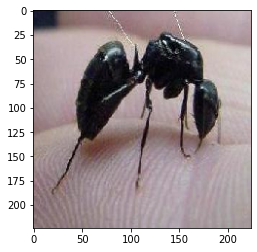

In [6]:
import matplotlib.pyplot as plt 
plt.imshow(known["ant"][0])

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import time 
# each feature 
def extract_feature(model, src_image):
    img_input = image.img_to_array(src_image)
    img_input = np.expand_dims(img_input, axis=0) # == [x]
    img_input = preprocess_input(img_input)
    return model.predict(img_input)[0].flatten()

model = VGG16(weights="model/vgg16", include_top=False)

features = {}
marker = time.time()
count = 0
# make get features:
for kind in known:
    features[kind] = alist = []
    for i in range(len(known[kind])):
        count += 1
        alist.append(extract_feature(model, known[kind][i]))
time_ellapsed = time.time() - marker
print("Extract features of %d image(s) takes %.2fs" % (count, time_ellapsed), ", avg =", time_ellapsed / count, " seconds")

Extract features of 147 image(s) takes 27.10s , avg = 0.18438456496413874  seconds


In [9]:
from sklearn.metrics.pairwise import cosine_similarity 
import numpy as np
src_image = image.load_img("data/small-set/query-data/ant/image_0035.jpg", target_size=(224, 224))
img_feature = extract_feature(model, src_image)
# for kind in known:
# cosines = cosine_similarity(features["ant"], [img_input])
print(cosine_similarity(features["ant"], [img_feature])[0])
print(cosine_similarity(features["cellphone"], [img_feature])[0])
print(cosine_similarity(features["headphone"], [img_feature])[0])
print(cosine_similarity(features["windsor_chair"], [img_feature])[0])

[0.2882235]
[0.11982185]
[0.08094156]
[0.10185501]


Searching done in 0.020018815994262695 second. Iterated over 147 sample(s). Rendering...


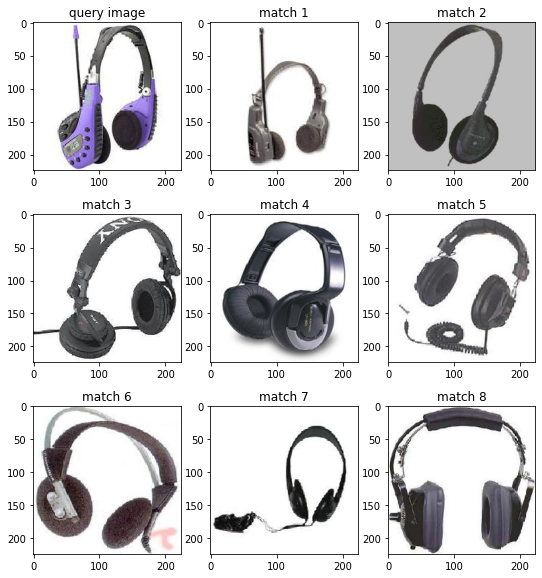

In [10]:
from sklearn.metrics.pairwise import cosine_similarity 
import numpy as np
import time

def search(query_image_path):
    # Draw images:
    src_image = image.load_img(query_image_path, target_size=(224, 224))
    img_feature = extract_feature(model, src_image)

    marker = time.time()
    similarities = []
    for kind, feature_matrix in features.items():
        index = 0
        for cosine in cosine_similarity(feature_matrix, [img_feature]):
            similarities.append((cosine[0], (kind, index)))
            index += 1
    similarities.sort(reverse=True)
    print("Searching done in", time.time()-marker, "second. Iterated over", len(similarities), "sample(s). Rendering...")

    import matplotlib.pyplot as plt 
    fig=plt.figure(figsize=(9, 10))

    top_k = 8
    # subplot_index = 0
    for i in range(top_k+1):
        fig.add_subplot(3, 3, i+1)
        if i == 0:
            plt.title("query image")
            plt.imshow(src_image)
            continue

        plt.title("match %d" % i)
        known_element = similarities[i-1]
        plt.imshow(known[known_element[1][0]][known_element[1][1]])
query_image_path = "data/small-set/query-data/headphone/image_0035.jpg"
search(query_image_path)

Searching done in 0.02101898193359375 second. Iterated over 147 sample(s). Rendering...


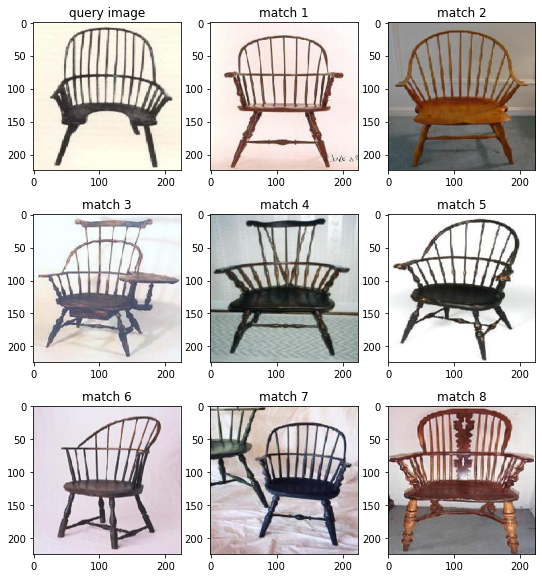

In [11]:
query_image_path = "data/small-set/query-data/windsor_chair/image_0050.jpg"
search(query_image_path)

# Use spotify/annoy for indexing


In [9]:
!pip3 install annoy

^C


In [12]:
from annoy import AnnoyIndex
import random

indexer = AnnoyIndex(25088, "angular")
images = []
for kind in known:
    images.extend(known[kind])

feature_array = []
for kind in known:
    feature_array.extend(features[kind])

for i in range(len(feature_array)):
    indexer.add_item(i, feature_array[i])
indexer.build(6) # 10 trees

True

True

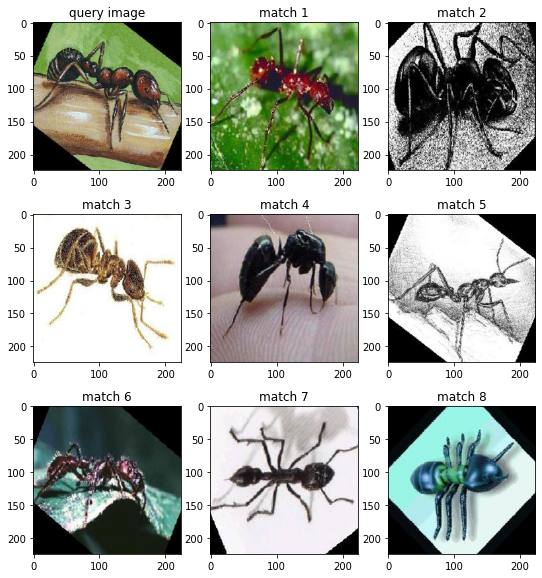

In [13]:
import matplotlib.pyplot as plt

query_image_path = "data/small-set/query-data/ant/image_0035.jpg"
src_image = image.load_img(query_image_path, target_size=(224, 224))
img_feature = extract_feature(model, src_image)

hits = indexer.get_nns_by_vector(img_feature, 8, search_k=3, include_distances=False)

def show_hits(images, src_image, hits):
    fig=plt.figure(figsize=(9, 10))

    top_k = 8
    # subplot_index = 0
    for i in range(top_k+1):
        fig.add_subplot(3, 3, i+1)
        if i == 0:
            plt.title("query image")
            plt.imshow(src_image)
            continue

        plt.title("match %d" % i)
        plt.imshow(images[hits[i-1]])
show_hits(images, src_image, hits)
indexer.save('test.ann')

Hits: [81, 95, 100, 82, 92, 84, 99, 77, 71, 69, 73, 97, 76, 98, 93, 22, 89, 88, 72, 17, 87, 86, 70, 78, 68, 114, 80, 101, 85, 137, 91, 119, 31, 75, 117, 79, 121, 104, 63, 135, 20, 24, 34, 128, 106, 74, 120, 133, 57, 51, 127, 6, 116, 59, 109, 30, 26, 12, 130, 15, 94, 49, 18, 129, 65, 110, 146, 3, 61, 32, 115, 0, 83, 48, 142, 112, 16, 54, 43, 62, 141, 66, 42, 96, 132, 53, 13, 123, 126, 11, 125, 143, 4, 21, 29, 36, 64, 56, 139, 10]


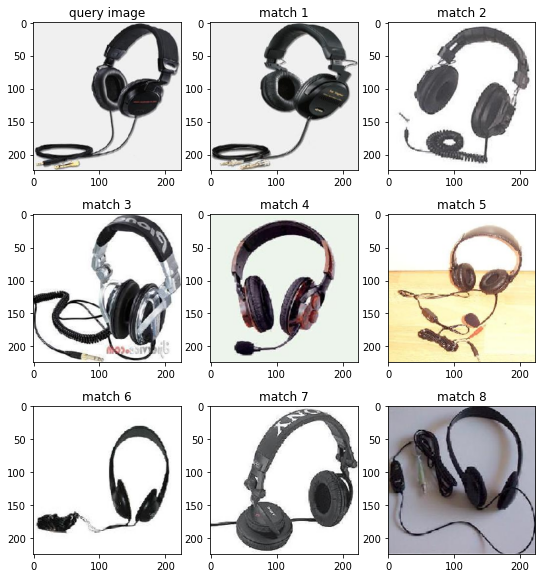

In [14]:
# Try reload model from file:
from annoy import AnnoyIndex
import random

query_image_path = "data/small-set/query-data/headphone/image_0042.jpg"
src_image = image.load_img(query_image_path, target_size=(224, 224))
img_feature = extract_feature(model, src_image)

indexer = AnnoyIndex(25088, "angular")
indexer.load("test.ann")
hits = indexer.get_nns_by_vector(img_feature, 100, search_k=-1, include_distances=False)
print("Hits:", hits)
show_hits(images, src_image, hits[:8])


## Try a different model

In [15]:
from tensorflow.keras.applications import MobileNetV2
model = MobileNetV2(
    include_top=False,
    weights="model/mobilenetv2_notop",
)
features = {}
marker = time.time()
count = 0
# make get features:
for kind in known:
    features[kind] = alist = []
    for i in range(len(known[kind])):
        count += 1
        alist.append(extract_feature(model, known[kind][i]))
time_ellapsed = time.time() - marker
print("Extract features of %d image(s) takes %.2fs" % (count, time_ellapsed), ", avg =", time_ellapsed / count, " seconds")

Extract features of 147 image(s) takes 8.14s , avg = 0.05539727697567064  seconds


In [19]:
from annoy import AnnoyIndex
import random

indexer = AnnoyIndex(62720, "angular")
images = []
for kind in known:
    images.extend(known[kind])

feature_array = []
for kind in known:
    feature_array.extend(features[kind])

marker = time.time()
for i in range(len(feature_array)):
    indexer.add_item(i, feature_array[i])
indexer.build(6) # 10 trees

print("Indexing with annoy, dim: %d, done in %f second(s)" % (len(feature_array[0]), time.time()-marker))

Indexing with annoy, dim: 62720, done in 1.347906


Searching done in 0.017014 second(s)


True

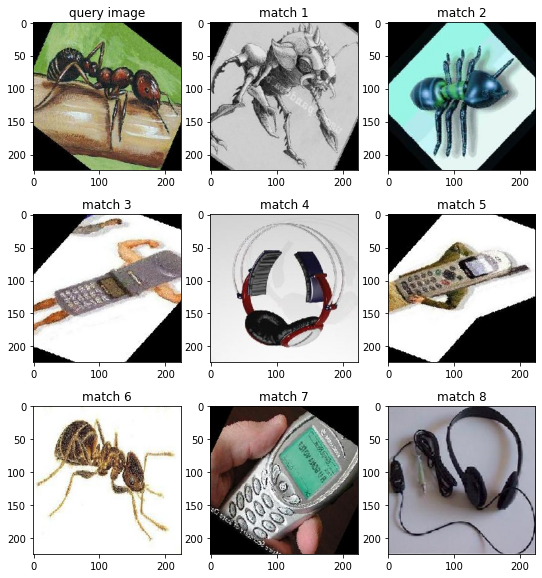

In [20]:

query_image_path = "data/small-set/query-data/ant/image_0035.jpg"
src_image = image.load_img(query_image_path, target_size=(224, 224))
img_feature = extract_feature(model, src_image)

marker = time.time()
hits = indexer.get_nns_by_vector(img_feature, 8, search_k=3, include_distances=False)
print("Searching done in %f second(s)" % (time.time()-marker))

def show_hits(images, src_image, hits):
    fig=plt.figure(figsize=(9, 10))

    top_k = 8
    # subplot_index = 0
    for i in range(top_k+1):
        fig.add_subplot(3, 3, i+1)
        if i == 0:
            plt.title("query image")
            plt.imshow(src_image)
            continue

        plt.title("match %d" % i)
        plt.imshow(images[hits[i-1]])
show_hits(images, src_image, hits)
indexer.save('test.ann')